In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from classes import Bandpasses, Sed, LightCurve, SNSurvey

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the LSST filters

In [3]:
bandpasses = Bandpasses()

Simulate a survey of SN1a

In [4]:
%%time
model = sncosmo.Model(source='salt2-extended')
params = {'z': 0, 't0': 0, 'x0': 1e-5, 'x1': 0.1, 'c': -0.1}
model.update(params)

survey = SNSurvey(model=model, zmax=0.75, area=1, cadence=1)
survey.simulate(bandpasses, norm=10, Ncpus=8)

print(survey)

SN Survey Simulation: 

    N obs = 356    
     zmin = 0      
     zmax = 0.75   
     area = 1      
 duration = 1000.0 
  cadence = 1      
flux errf = 0.05   

Model: 
source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 2.0
  phases     : [-20, .., 50] days
  wavelengths: [1700, .., 24990] Angstroms
parameters:
  z  = 0.0
  t0 = 0.0
  x0 = 1e-05
  x1 = 0.1
  c  = -0.1
CPU times: user 1.42 s, sys: 338 ms, total: 1.76 s
Wall time: 4.64 s


In [5]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 11100, 10)
lc = LightCurve(time, wavelen)
lc.from_model(model)

Now we start with a totally null light curve

In [6]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 11100, 10)
lcn = LightCurve(time, wavelen)
lcn.null()

Let's make the time-slice training sets:

In [7]:
%time training_sets = lcn.training_sets(survey.obs)

CPU times: user 9.79 s, sys: 61 ms, total: 9.85 s
Wall time: 9.83 s


Pull out a specific time

In [8]:
T = 0
objects = training_sets[T]

Now train an SED

In [9]:
sed = Sed()
sed.wavelen = np.arange(1000, 11100, 100)
sed.null()

sed = lcn.sed_slice(0)

%time model = sed.train(objects, bandpasses, fit_bias=True, return_model=True, verbose=True, Ncpus=1)

alpha = 0.4104
N_EDB = 39
Max width = 800
N_split = 1
beta = 100000000.0
Biases:
lsstu: -0.0000
lsstg: 0.0000
lsstr: 0.0000
lssti: -0.0000
lsstz: 0.0000
lssty: 0.0000
CPU times: user 3min 2s, sys: 2.26 s, total: 3min 4s
Wall time: 46.3 s


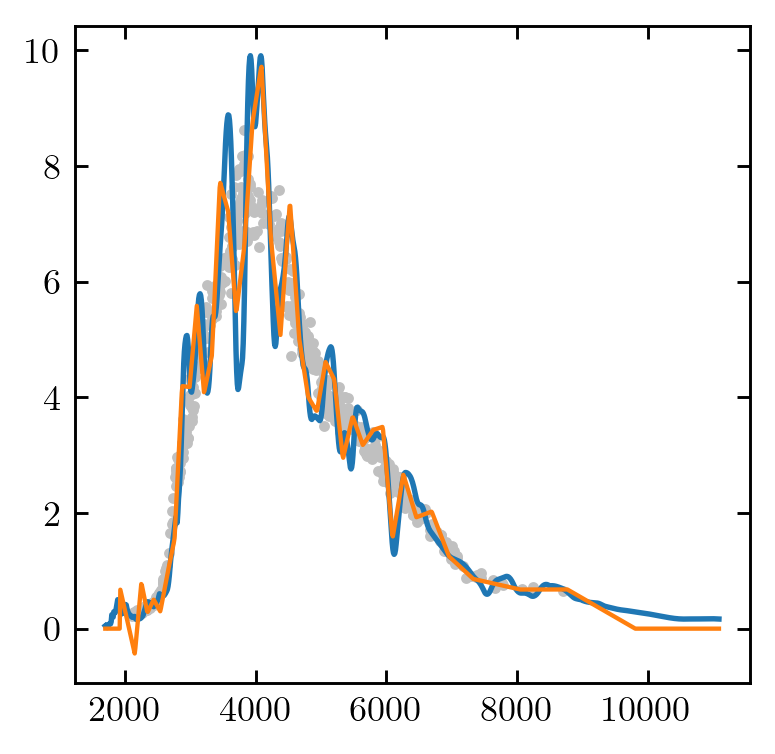

In [12]:
SED = lc.sed_slice(T)

plt.plot(SED.wavelen, SED.flambda, lw=1.5)
plt.plot(sed.wavelen, sed.flambda)

for obj in objects:
    wavelen = bandpasses.mean_wavelens(obj.photometry['filter'])/(1 + obj.specz)
    plt.scatter(wavelen, obj.photometry['flux'], c='silver')

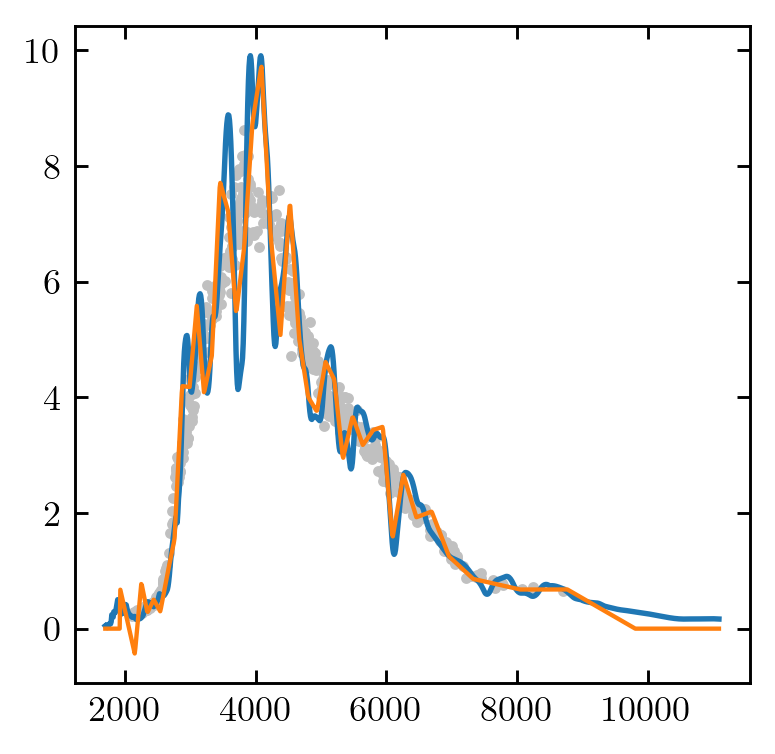

In [12]:
SED = lc.sed_slice(T)

plt.plot(SED.wavelen, SED.flambda, lw=1.5)
plt.plot(sed.wavelen, sed.flambda)

for obj in objects:
    wavelen = bandpasses.mean_wavelens(obj.photometry['filter'])/(1 + obj.specz)
    plt.scatter(wavelen, obj.photometry['flux'], c='silver')

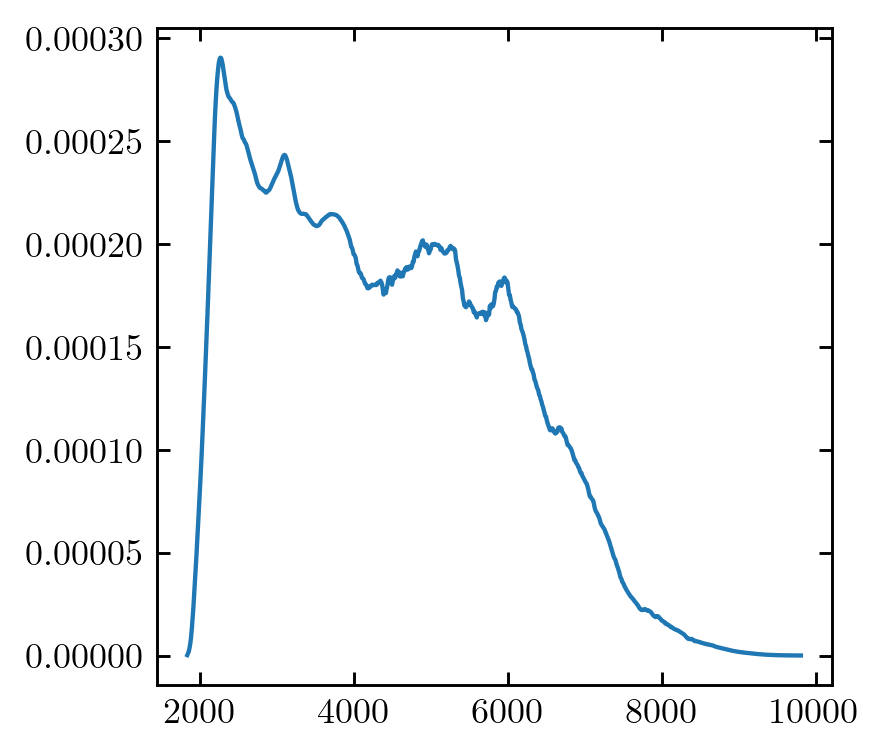

In [18]:
plt.plot(model.initbins,model.infoDen_)
plt.show()

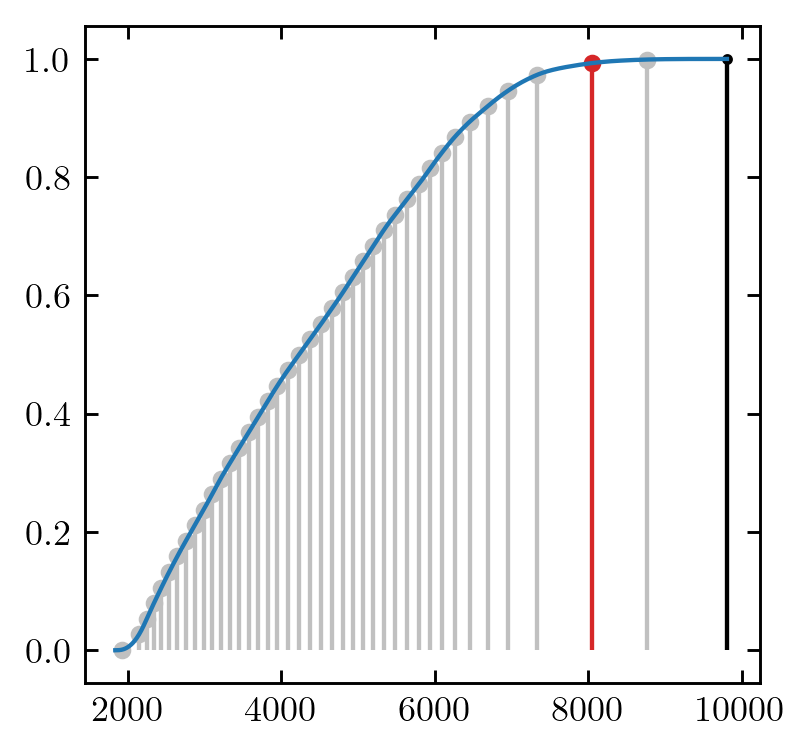

In [42]:
plt.plot(model.initbins, model.cumInfo_)
N = model.N_EDB + model.Nsplit_ - 1
for i,w in enumerate(model.allbins_):
    c = 'silver' if i < N - model.Nsplit_ or i == N else 'C3'
    
    I = np.interp(w, model.initbins, model.cumInfo_)
    plt.vlines(w, 0, I, color=c)
    plt.scatter(w, I, c=c, s=15)
    
plt.vlines(model.initbins[-1], 0, 1, color='k')
plt.scatter(model.initbins[-1], 1, c='k')